In [ ]:
#python notebook file which will contain data visualisations

### 1. Prepocessing and Data Visualizations

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from pmdarima.arima import auto_arima

/var/folders/d3/5_l3h7cd1c98_xcdw8_wgkbh0000gn/T/ipykernel_98483/102198586.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [95]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 656.2/656.2 kB 5.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 4.3 MB/s eta 0:00:0000:0100:01m


### 2. Functions

In [2]:
#function - creating two sequence out of which one predicts the other (from: https://github.com/krishnaik06/Time-Series-Forecasting/blob/master/UnivariateTimeSeries.ipynb)
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

#function - counting outliers in the time sereies for data observation
def count_outliers(time_series):
    pos_outlier, neg_outlier = 0, 0
    q1,q3 = np.nanpercentile(time_series,[25,75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    
    for num in time_series: 
      
    # checking condition 
        if num >= upper_bound: 
            pos_outlier += 1
  
        elif num <= lower_bound: 
            neg_outlier += 1
    
    print('Outliers in Asset Return Series: ', pos_outlier+neg_outlier) 
    print('Outliers exceeding Upper Bound in Asset Return Series: ', pos_outlier) 
    print('Outliers falling below Lower Bound in Asset Return Series: ', neg_outlier) 


#function - testing for stationarity
def test_stationarity(time_series):
    print('Results of dickey fuller test:')
    adft = adfuller(time_series,autolag='AIC')
    #dft outputs values without definitions -> manually naming them
    output = pd.Series(adft[0:4],index=['Test Statistic','p-value','Number of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

### 3. Loading Data

In [3]:
#general hyperparameter
input_steps = 1
output_steps = 1 #one day ahead prediction

In [4]:
# Initialize an empty dictionary to store the loaded DataFrames
data_dict = {}

# Define the directory where the CSV files are saved
directory = '/Users/cemakkus/PycharmProjects/Master/data/'

# Iterate through each file in the directory
for filename in os.listdir(directory):
    if filename.startswith('export_') and filename.endswith('.csv'):
        # Extract the ticker from the filename
        ticker = filename.replace('export_', '').replace('.csv', '')
        
        # Define the full file path
        file_path = os.path.join(directory, filename)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        data_dict[ticker] = df.iloc[:-output_steps]  # Select all rows except the last rows that contain nan's
        
        
        print(f'DataFrame for {ticker} loaded from {file_path}')


# At this point, data_dict contains all DataFrames, keyed and sorted by ticker
data_dict = {k: data_dict[k] for k in sorted(data_dict)}


DataFrame for SAF_PA loaded from /Users/cemakkus/PycharmProjects/Master/data/export_SAF_PA.csv
DataFrame for MUV2_DE loaded from /Users/cemakkus/PycharmProjects/Master/data/export_MUV2_DE.csv
DataFrame for ISP_MI loaded from /Users/cemakkus/PycharmProjects/Master/data/export_ISP_MI.csv
DataFrame for ASML_AS loaded from /Users/cemakkus/PycharmProjects/Master/data/export_ASML_AS.csv
DataFrame for BN_PA loaded from /Users/cemakkus/PycharmProjects/Master/data/export_BN_PA.csv
DataFrame for BBVA_MC loaded from /Users/cemakkus/PycharmProjects/Master/data/export_BBVA_MC.csv
DataFrame for CRH loaded from /Users/cemakkus/PycharmProjects/Master/data/export_CRH.csv
DataFrame for ITX_MC loaded from /Users/cemakkus/PycharmProjects/Master/data/export_ITX_MC.csv
DataFrame for BAYN_DE loaded from /Users/cemakkus/PycharmProjects/Master/data/export_BAYN_DE.csv
DataFrame for DB1_DE loaded from /Users/cemakkus/PycharmProjects/Master/data/export_DB1_DE.csv
DataFrame for ADS_DE loaded from /Users/cemakkus/P

In [5]:
data_dict.keys()

dict_keys(['ABI_BR', 'ADS_DE', 'ADYEN_AS', 'AD_AS', 'AIR_PA', 'AI_PA', 'ALV_DE', 'ASML_AS', 'BAS_DE', 'BAYN_DE', 'BBVA_MC', 'BMW_DE', 'BNP_PA', 'BN_PA', 'CRH', 'CS_PA', 'DB1_DE', 'DG_PA', 'DHL_DE', 'DTE_DE', 'EL_PA', 'ENEL_MI', 'ENI_MI', 'FLTR_L', 'IBE_MC', 'IFX_DE', 'INGA_AS', 'ISP_MI', 'ITX_MC', 'KER_PA', 'MBG_DE', 'MC_PA', 'MUV2_DE', 'NDA-SE_ST', 'NOKIA_HE', 'OR_PA', 'PRX_AS', 'RI_PA', 'RMS_PA', 'SAF_PA', 'SAN_MC', 'SAN_PA', 'SAP_DE', 'SIE_DE', 'STLAM_MI', 'SU_PA', 'TTE_PA', 'UCG_MI', 'VNA_DE', 'VOW3_DE'])

In [6]:
num_keys = len(data_dict.keys())
print(f'The number of keys in the dictionary: {num_keys}')


The number of keys in the dictionary: 50


In [7]:
data_dict['SIE_DE'] 

,date,company,ISIN,positive,negative,sentiment,volume,esg_score,e_score,s_score,g_score,general_risk_score,esg_risk_score,credit_risk_score,immediate_risk_score,Close,1d_return,5d_return
0,2020-01-02,company:siemens,DE0007236101,199.000000,29.000000,0.869565,559.000000,1.489191,7.193914,2.306927,2.174921,8.434064,8.138645,8.926194,8.382147,118.639999,-0.019218,-0.002023
1,2020-01-03,company:siemens,DE0007236101,88.000000,32.666667,0.675735,288.666667,1.635644,7.077792,2.439786,2.404650,8.205056,7.875408,8.780398,8.092971,116.360001,-0.004641,-0.003094
2,2020-01-06,company:siemens,DE0007236101,311.000000,33.000000,0.901734,601.000000,1.693354,7.096961,2.451860,2.559519,8.068867,7.776818,8.721302,7.892920,115.820000,0.006389,-0.000518
3,2020-01-07,company:siemens,DE0007236101,352.000000,120.000000,0.744726,869.000000,2.008764,6.836974,2.783116,2.969960,7.538455,7.192061,8.325717,7.263807,116.559998,0.004118,-0.001373
4,2020-01-08,company:siemens,DE0007236101,319.000000,88.000000,0.782396,944.000000,2.163326,6.737553,2.958472,3.116807,7.267218,6.907058,8.101656,6.997641,117.040001,0.011620,-0.011107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1022,2024-01-10,company:siemens,DE0007236101,501.000000,27.000000,0.947170,797.000000,6.678720,6.580659,5.458245,4.652153,4.040066,1.945436,0.000000,2.814694,160.779999,-0.000746,-0.011444
1023,2024-01-11,company:siemens,DE0007236101,387.000000,21.000000,0.946341,810.000000,6.645452,6.556256,5.417111,4.663803,3.978141,1.871282,0.000000,2.742754,160.660004,0.015312,NaN
1024,2024-01-12,company:siemens,DE0007236101,193.666667,14.000000,0.934691,369.666667,6.698031,6.622693,5.401250,4.649058,4.208508,1.904625,0.000000,2.781496,163.119995,-0.007357,NaN
1025,2024-01-15,company:siemens,DE0007236101,213.000000,15.000000,0.930435,436.000000,6.660626,6.594723,5.355684,4.678080,4.220383,1.781693,0.000000,2.585593,161.919998,-0.004694,NaN


In [8]:
sorted_data_dict = {k: data_dict[k] for k in sorted(data_dict)}

In [9]:
sorted_data_dict.keys()

dict_keys(['ABI_BR', 'ADS_DE', 'ADYEN_AS', 'AD_AS', 'AIR_PA', 'AI_PA', 'ALV_DE', 'ASML_AS', 'BAS_DE', 'BAYN_DE', 'BBVA_MC', 'BMW_DE', 'BNP_PA', 'BN_PA', 'CRH', 'CS_PA', 'DB1_DE', 'DG_PA', 'DHL_DE', 'DTE_DE', 'EL_PA', 'ENEL_MI', 'ENI_MI', 'FLTR_L', 'IBE_MC', 'IFX_DE', 'INGA_AS', 'ISP_MI', 'ITX_MC', 'KER_PA', 'MBG_DE', 'MC_PA', 'MUV2_DE', 'NDA-SE_ST', 'NOKIA_HE', 'OR_PA', 'PRX_AS', 'RI_PA', 'RMS_PA', 'SAF_PA', 'SAN_MC', 'SAN_PA', 'SAP_DE', 'SIE_DE', 'STLAM_MI', 'SU_PA', 'TTE_PA', 'UCG_MI', 'VNA_DE', 'VOW3_DE'])

In [10]:
sorted_data_dict['SAP_DE']

,date,company,ISIN,positive,negative,sentiment,volume,esg_score,e_score,s_score,g_score,general_risk_score,esg_risk_score,credit_risk_score,immediate_risk_score,Close,1d_return,5d_return
0,2020-01-02,company:sap,DE0007164600,239.000000,25.000000,0.902256,577.000000,2.477782,5.590420,6.056558,2.790822,8.898208,8.518763,9.059059,7.286432,122.000000,-0.012623,0.009508
1,2020-01-03,company:sap,DE0007164600,95.333333,17.333333,0.791188,215.666667,2.827697,5.438510,5.846236,3.127057,8.620099,8.137393,8.804855,6.650232,120.459999,-0.007471,0.027395
2,2020-01-06,company:sap,DE0007164600,298.000000,35.000000,0.892537,619.000000,3.029589,5.364970,5.731612,3.334905,8.450698,7.899642,8.640202,6.206795,119.559998,0.004517,0.035129
3,2020-01-07,company:sap,DE0007164600,562.000000,74.000000,0.882445,993.000000,3.463783,5.233897,5.517687,3.728406,7.872805,7.190220,8.105424,5.193455,120.099998,0.005995,0.029142
4,2020-01-08,company:sap,DE0007164600,308.000000,72.000000,0.808901,786.000000,3.604520,5.196111,5.460169,3.856754,7.635323,6.885807,7.856910,4.807203,120.820000,0.019368,0.018043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1022,2024-01-10,company:sap,DE0007164600,335.000000,233.000000,0.589474,906.000000,3.534495,5.997612,4.339305,3.778603,5.391929,4.403973,0.000000,5.284370,142.039993,-0.001126,0.019572
1023,2024-01-11,company:sap,DE0007164600,488.000000,223.000000,0.685835,1033.000000,3.025249,5.857778,4.460554,3.097214,6.274508,5.378073,6.881363,6.720926,141.880005,0.021004,NaN
1024,2024-01-12,company:sap,DE0007164600,161.000000,22.000000,0.899605,263.333333,2.376450,5.739723,4.568529,2.363558,7.290106,6.562143,7.665291,7.895203,144.860001,-0.002071,NaN
1025,2024-01-15,company:sap,DE0007164600,321.000000,56.000000,0.849604,610.000000,1.995999,5.667875,4.624281,1.955280,7.832766,7.206568,8.131393,8.418424,144.559998,0.000138,NaN


### 4. Stock Price Plots

In [11]:
data_dict['SAP_DE']['date'] = pd.to_datetime(data_dict['SAP_DE']['date'])
data_dict['SAP_DE'] = data_dict['SAP_DE'].set_index('date')


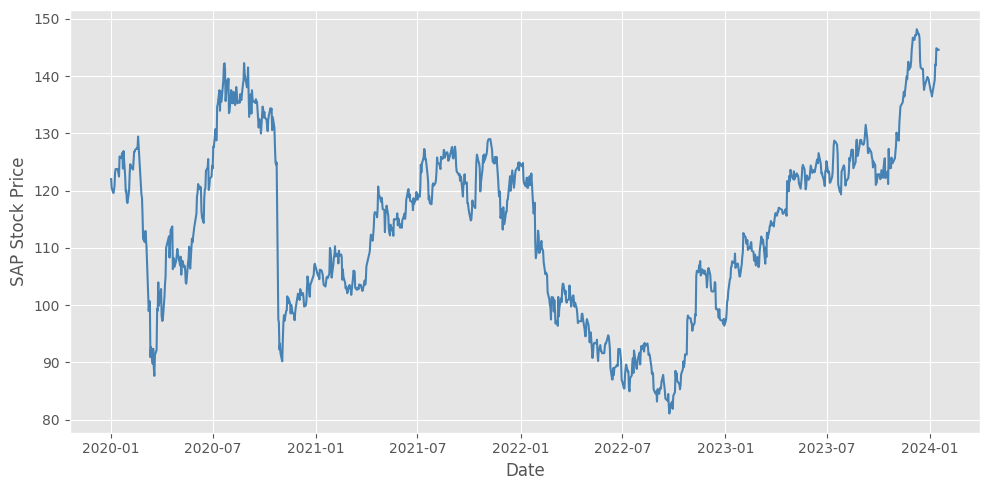

In [12]:
#plot - closing prices of sap
plt.figure(figsize=(10,5))
plt.plot(data_dict['SAP_DE']['Close'], color='steelblue', label = 'Stock Price')
plt.xlabel('Date')
plt.ylabel('SAP Stock Price')
#plt.legend()
plt.tight_layout()
#plt.savefig('sp_sap.png')

### 5. Asset Return Plots

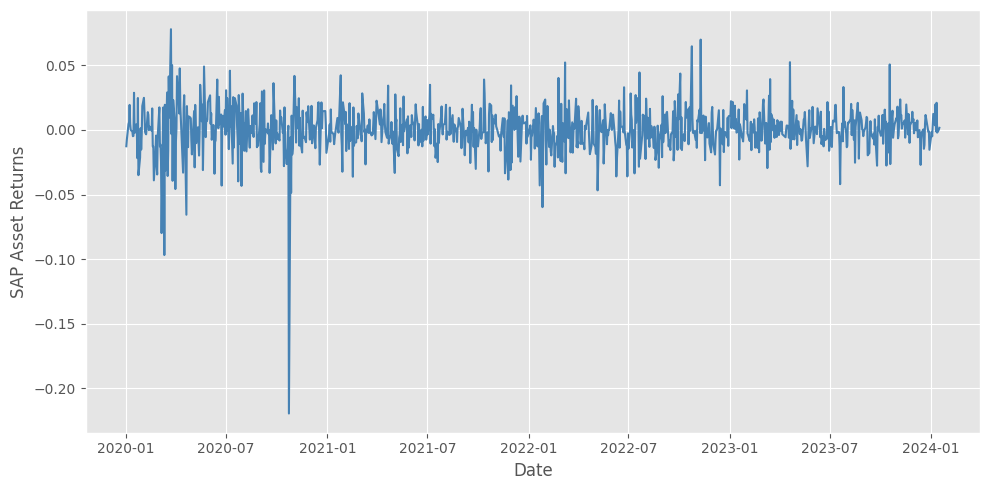

In [13]:
#plot - closing prices of sap
plt.figure(figsize=(10,5))
plt.plot(data_dict['SAP_DE']['1d_return'], color='steelblue', label = 'Asset Returns')
plt.xlabel('Date')
plt.ylabel('SAP Asset Returns')
#plt.legend()
plt.tight_layout()
#plt.savefig('sp_sap.png')

In [14]:
# Filter rows where '1d_return' is greater than 0.1 or less than -0.1
filtered_rows = data_dict['SAP_DE'].loc[(data_dict['SAP_DE']['1d_return'] > 0.1) | (data_dict['SAP_DE']['1d_return'] < -0.1)]

filtered_rows


,company,ISIN,positive,negative,sentiment,volume,esg_score,e_score,s_score,g_score,general_risk_score,esg_risk_score,credit_risk_score,immediate_risk_score,Close,1d_return,5d_return
date,,,,,,,,,,,,,,,,,
2020-10-23,company:sap,DE0007164600,278.0,161.0,0.704455,799.0,3.485356,5.361798,4.263946,3.763828,5.955488,4.883243,2.26784,5.827275,124.900002,-0.219376,-0.267494


In [15]:
# # Initialize a list to hold the DataFrames
# subsequent_dfs = []

# # Iterate through the indices and get the next 10 rows for each
# for idx in indices:
#     # Find the integer location for the current index
#     int_location = data_dict['SAP_DE'].index.get_loc(idx)
    
#     # Check if the end location is beyond the length of the DataFrame
#     end_location = min(int_location + 11, len(data_dict['SAP_DE']))
    
#     # Get the next 10 rows from the current index using iloc
#     subsequent_rows = data_dict['SAP_DE'].iloc[int_location:end_location]
    
#     # Append the DataFrame to the list
#     subsequent_dfs.append(subsequent_rows)

# # Concatenate all the DataFrames in the list
# resulting_rows = pd.concat(subsequent_dfs).drop_duplicates()

# # Reset index of the resulting DataFrame (optional, for better readability)
# resulting_rows = resulting_rows.reset_index(drop=True)

# resulting_rows


NameError: name 'indices' is not defined

In [16]:
#outliers of sap asset return series
count_outliers(data_dict['SAP_DE']['1d_return'])

Outliers in Asset Return Series:  46
Outliers exceeding Upper Bound in Asset Return Series:  21
Outliers falling below Lower Bound in Asset Return Series:  25


In [17]:
q1, q3 = np.percentile(data_dict['SAP_DE']['1d_return'], [25, 75])
q1, q3


(-0.007832020254103199, 0.00933054081455325)

### 6. Asset Return Histograms

In [18]:
#hyperparameter for histogram plots
bins = 50

/var/folders/d3/5_l3h7cd1c98_xcdw8_wgkbh0000gn/T/ipykernel_98483/1058912725.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_dict['SAP_DE']['1d_return'], hist = True, kde = False, bins = bins, label = 'histogram', norm_hist = True)
/var/folders/d3/5_l3h7cd1c98_xcdw8_wgkbh0000gn/T/ipykernel_98483/1058912725.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see


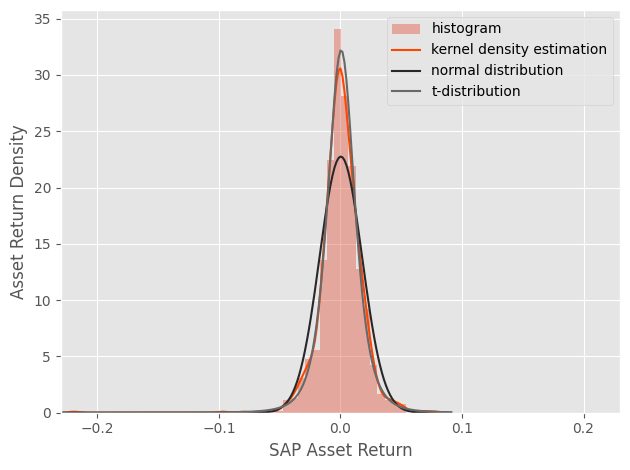

In [19]:
#histogram - closing prices of sap
sns.distplot(data_dict['SAP_DE']['1d_return'], hist = True, kde = False, bins = bins, label = 'histogram', norm_hist = True)
sns.distplot(data_dict['SAP_DE']['1d_return'], hist = False, kde = True, color= 'orangered', label = 'kernel density estimation')
sns.distplot(data_dict['SAP_DE']['1d_return'], hist = False, kde = False, fit = stats.norm, label = 'normal distribution')
sns.distplot(data_dict['SAP_DE']['1d_return'], fit_kws={"color":"dimgrey"}, hist = False, kde = False, fit = stats.t, color = 'black', label = 't-distribution')
plt.xlabel('SAP Asset Return')
plt.ylabel('Asset Return Density')
plt.xlim(-0.23, 0.23)
plt.legend()
plt.tight_layout()
#plt.savefig('hist_ar_sap.png')

In [20]:
#basic figures about sap asset returns
print('Mean of SAP (Asset Return Series):',round((data_dict['SAP_DE']['1d_return']).mean(),6))
print('Standard Deviation of SAP (Asset Return Series):',round((data_dict['SAP_DE']['1d_return']).std(),6))
print('Average Daily Fluctuation of SAP (Asset Return Series):',round((abs(data_dict['SAP_DE']['1d_return'])).mean(),6))

Mean of SAP (Asset Return Series): 0.000325
Standard Deviation of SAP (Asset Return Series): 0.017545
Average Daily Fluctuation of SAP (Asset Return Series): 0.011828


### 7. Autocorrelation Plots

In [21]:
#hyperparameter for acf & pacf plots
lags = 12

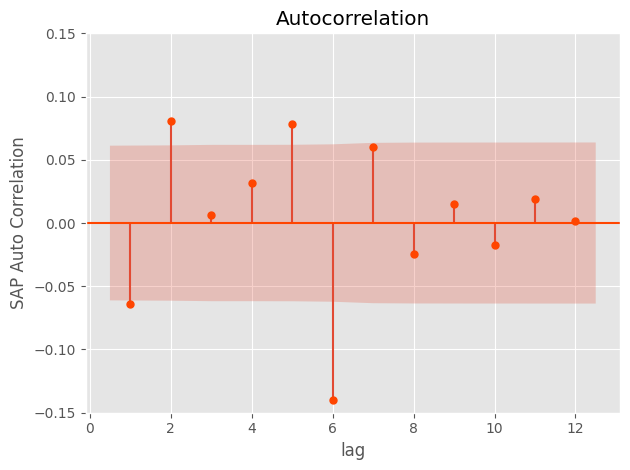

In [22]:
#autocorrelation plot - asset return of dax
plot_acf(data_dict['SAP_DE']['1d_return'], alpha=0.05, lags=lags, zero = False, color = 'orangered')
plt.xlabel('lag')
plt.ylabel('SAP Auto Correlation')
plt.ylim(-0.15, 0.15)
plt.tight_layout()
#plt.savefig('acf_ar_dax.png')

### 8. Partial Autocorrelation Plots

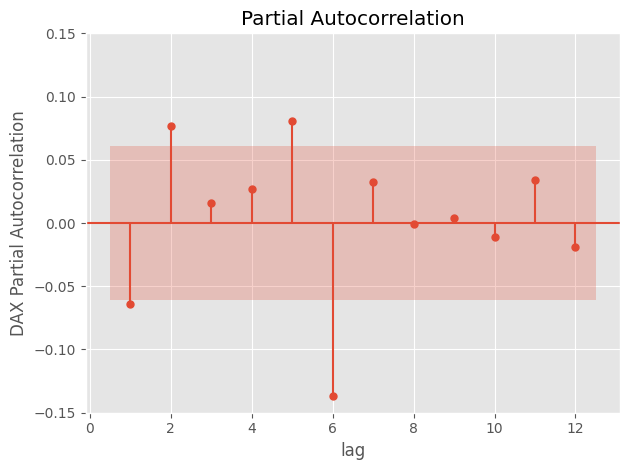

In [23]:
#partial autocorrelation plot - asset return of dax
plot_pacf(data_dict['SAP_DE']['1d_return'], alpha=0.05, lags=lags, zero = False)
plt.xlabel('lag')
plt.ylabel('DAX Partial Autocorrelation')
plt.ylim(-0.15, 0.15)
plt.tight_layout()
#plt.savefig('pacf_ar_dax.png')

### 9. Testing Stationarity

In [24]:
#Test for stationarity - dax
test_stationarity(data_dict['SAP_DE']['1d_return'])

Results of dickey fuller test:
Test Statistic                -1.333666e+01
p-value                        6.033352e-25
Number of lags used            5.000000e+00
Number of observations used    1.021000e+03
critical value (1%)           -3.436771e+00
critical value (5%)           -2.864375e+00
critical value (10%)          -2.568279e+00
dtype: float64


In [25]:
#Test for stationarity - dax
test_stationarity(data_dict['SAP_DE']['Close'])

Results of dickey fuller test:
Test Statistic                   -1.860549
p-value                           0.350841
Number of lags used               7.000000
Number of observations used    1019.000000
critical value (1%)              -3.436784
critical value (5%)              -2.864381
critical value (10%)             -2.568282
dtype: float64


### 10. Train/Test Splits for ARIMA & Determining Best ARIMA models

In [26]:
#hyperparameter for feature engineering (at this part of the code, so models use exactly the same dates for their predictions)
n_features = 2
window = 10

In [27]:
#hyperparameter for train/test split
train_test_ratio = 7/10

In [28]:
#split dax asset returns into train and test set
train_arima_SAP, test_arima_SAP = train_test_split(data_dict['SAP_DE']['1d_return'], test_size=1-train_test_ratio, shuffle = False)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3635.671, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-3636.696, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-3636.272, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-3638.508, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-3636.710, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-3637.036, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-3636.571, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-3634.744, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-3636.538, Time=0.15 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 0.629 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  718
Model:               SARIMAX(2, 0, 0)   Log Likelihood                1822.254
Date:                Thu, 08 Feb 2024   

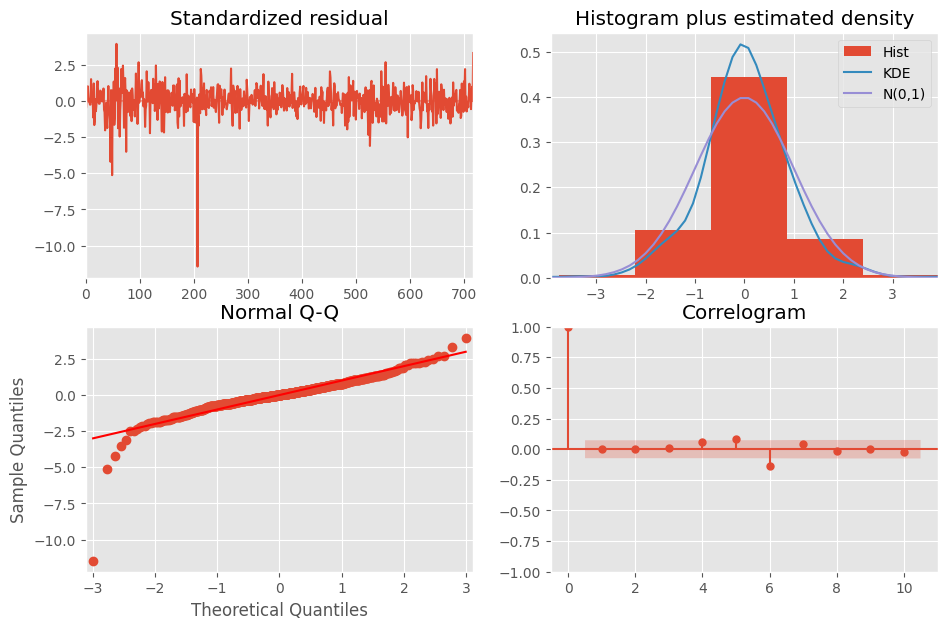

In [29]:
#determining most suitable arima order for dax prediction
autoarima = auto_arima(train_arima_SAP, 
                      start_p=0, start_q=0,  #minimum p and q
                      test='adf',            #use augmented dickey-fuller test to find optimal 'd'
                      max_p=3, max_q=3,      #maximum p and q
                      d=None,                #let model determine 'd'
                      seasonal=False,        #no seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(autoarima.summary())
autoarima.plot_diagnostics(figsize=(11,7))
plt.show()

In [30]:
#split dax asset returns into train and test set
train_arima_SIE, test_arima_SIE = train_test_split(data_dict['SIE_DE']['1d_return'], test_size=1-train_test_ratio, shuffle = False)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3450.390, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-3448.932, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-3448.917, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-3446.868, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-3448.423, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.184 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  718
Model:                        SARIMAX   Log Likelihood                1726.195
Date:                Thu, 08 Feb 2024   AIC                          -3450.390
Time:                        21:21:38   BIC                          -3445.813
Sample:                             0   HQIC                         -3448.623
                                - 718                                  

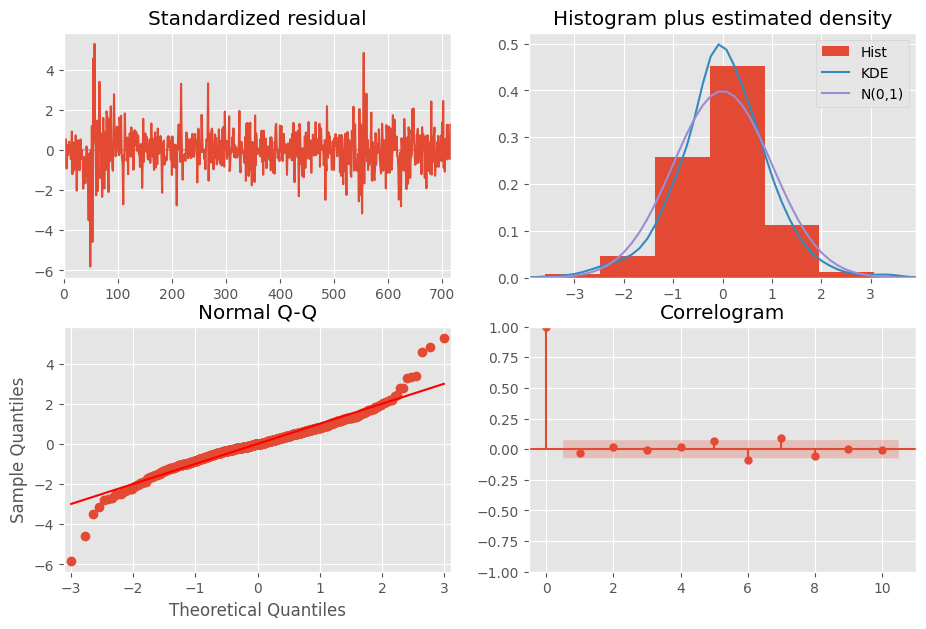

In [31]:
#determining most suitable arima order for sie prediction
autoarima = auto_arima(train_arima_SIE, 
                      start_p=0, start_q=0,  #minimum p and q
                      test='adf',            #use augmented dickey-fuller test to find optimal 'd'
                      max_p=3, max_q=3,      #maximum p and q
                      d=None,                #let model determine 'd'
                      seasonal=False,        #no seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(autoarima.summary())
autoarima.plot_diagnostics(figsize=(11,7))
plt.show()

In [32]:
#split dax asset returns into train and test set
train_arima_DTE, test_arima_DTE = train_test_split(data_dict['DTE_DE']['1d_return'], test_size=1-train_test_ratio, shuffle = False)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3947.287, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-3948.811, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-3948.265, Time=0.52 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-3952.003, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-3954.815, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-3952.857, Time=0.57 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-3944.821, Time=0.31 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-3953.327, Time=0.19 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 1.858 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  718
Model:               SARIMAX(3, 0, 0)   Log Likelihood                1981.407
Date:                Thu, 08 Feb 2024   AIC                          -3954.815
Time:                       

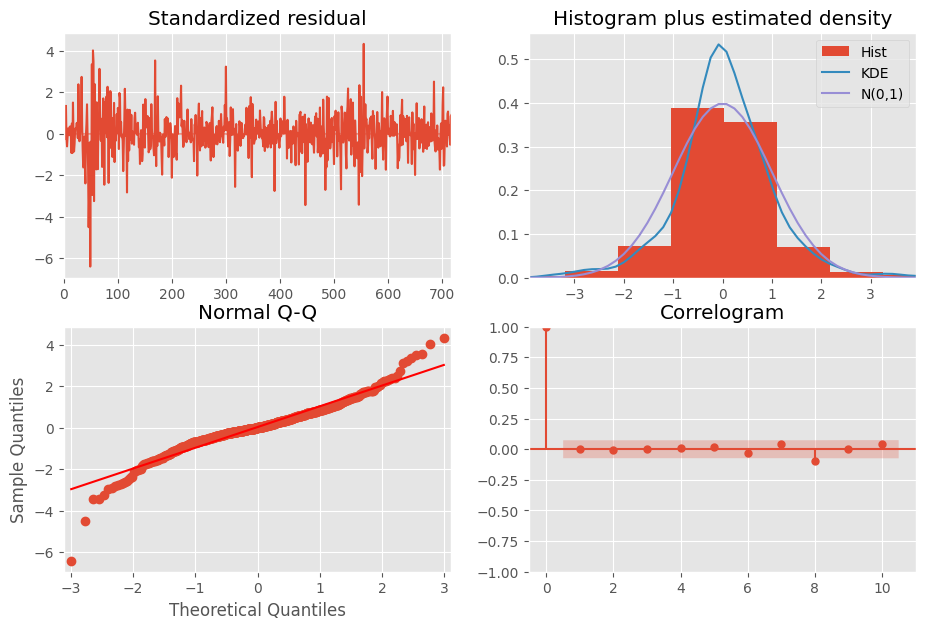

In [33]:
#determining most suitable arima order for sie prediction
autoarima = auto_arima(train_arima_DTE, 
                      start_p=0, start_q=0,  #minimum p and q
                      test='adf',            #use augmented dickey-fuller test to find optimal 'd'
                      max_p=3, max_q=3,      #maximum p and q
                      d=None,                #let model determine 'd'
                      seasonal=False,        #no seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(autoarima.summary())
autoarima.plot_diagnostics(figsize=(11,7))
plt.show()

### 11. Feature Engineering

In [34]:
#feature engineering for other top 3 german components in eurostoxx50 prediction
rolmean_SAP = data_dict['SAP_DE']['1d_return'].rolling(window).mean()
rolstd_SAP = data_dict['SAP_DE']['1d_return'].rolling(window).std()

rolmean_SIE = data_dict['SIE_DE']['1d_return'].rolling(window).mean()
rolstd_SIE = data_dict['SIE_DE']['1d_return'].rolling(window).std()

rolmean_DTE = data_dict['DTE_DE']['1d_return'].rolling(window).mean()
rolstd_DTE = data_dict['DTE_DE']['1d_return'].rolling(window).std()

#adding features as columns in dataframe for dax
data_dict['SAP_DE']['Rolling Mean'] = rolmean_SAP
data_dict['SAP_DE']['Rolling Std'] = rolstd_SAP

data_dict['SIE_DE']['Rolling Mean'] = rolmean_SIE
data_dict['SIE_DE']['Rolling Std'] = rolstd_SIE

#adding features as columns in dataframe for dax
data_dict['DTE_DE']['Rolling Mean'] = rolmean_DTE
data_dict['DTE_DE']['Rolling Std'] = rolstd_DTE

In [35]:
data_dict['SAP_DE']['1d_return']

date
2020-01-02   -0.012623
2020-01-03   -0.007471
2020-01-06    0.004517
2020-01-07    0.005995
2020-01-08    0.019368
                ...   
2024-01-10   -0.001126
2024-01-11    0.021004
2024-01-12   -0.002071
2024-01-15    0.000138
2024-01-16    0.001660
Name: 1d_return, Length: 1027, dtype: float64

In [36]:
data_dict['SAP_DE'][['Rolling Mean']]

,Rolling Mean
date,
2020-01-02,NaN
2020-01-03,NaN
2020-01-06,NaN
2020-01-07,NaN
2020-01-08,NaN
...,...
2024-01-10,0.001491
2024-01-11,0.003734
2024-01-12,0.003641


In [37]:
data_dict['SAP_DE']['1d_return'][output_steps:]

date
2020-01-03   -0.007471
2020-01-06    0.004517
2020-01-07    0.005995
2020-01-08    0.019368
2020-01-09    0.004872
                ...   
2024-01-10   -0.001126
2024-01-11    0.021004
2024-01-12   -0.002071
2024-01-15    0.000138
2024-01-16    0.001660
Name: 1d_return, Length: 1026, dtype: float64

In [38]:
#disregarding rows for which feature values can not be generated - top 3 german components
data_dict['SAP_DE'] = data_dict['SAP_DE'][window-1:]

data_dict['SIE_DE'] = data_dict['SIE_DE'][window-1:]

data_dict['DTE_DE'] = data_dict['DTE_DE'][window-1:]

In [40]:
data_dict['SAP_DE']

,company,ISIN,positive,negative,sentiment,volume,esg_score,e_score,s_score,g_score,general_risk_score,esg_risk_score,credit_risk_score,immediate_risk_score,Close,1d_return,5d_return,Rolling Mean,Rolling Std
date,,,,,,,,,,,,,,,,,,,
2020-01-15,company:sap,DE0007164600,438.000000,41.000000,0.912682,1007.000000,3.995202,5.113659,5.633509,4.199947,5.454003,4.519858,0.000000,3.627436,123.000000,-0.004553,0.029268,0.000396,0.008912
2020-01-16,company:sap,DE0007164600,500.000000,56.000000,0.897849,1175.000000,3.969499,5.115419,5.680735,4.179644,5.497494,4.566708,0.000000,3.720626,122.440002,0.028749,0.011434,0.004533,0.011441
2020-01-17,company:sap,DE0007164600,238.666667,21.333333,0.876859,475.666667,3.962576,5.136020,5.643958,4.188857,5.465654,4.545760,0.000000,3.799935,125.959999,-0.002382,0.007463,0.005042,0.010950
2020-01-20,company:sap,DE0007164600,416.000000,37.000000,0.916484,770.000000,3.888357,5.170561,5.649165,4.148302,5.607866,4.691917,6.182072,4.038308,125.660004,0.004297,-0.025466,0.005020,0.010951
2020-01-21,company:sap,DE0007164600,652.000000,51.000000,0.926241,1225.000000,3.875312,5.201468,5.654158,4.137257,5.545911,4.623552,6.163872,4.155238,126.199997,0.003170,-0.050396,0.004737,0.010960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-10,company:sap,DE0007164600,335.000000,233.000000,0.589474,906.000000,3.534495,5.997612,4.339305,3.778603,5.391929,4.403973,0.000000,5.284370,142.039993,-0.001126,0.019572,0.001491,0.009583
2024-01-11,company:sap,DE0007164600,488.000000,223.000000,0.685835,1033.000000,3.025249,5.857778,4.460554,3.097214,6.274508,5.378073,6.881363,6.720926,141.880005,0.021004,NaN,0.003734,0.011296
2024-01-12,company:sap,DE0007164600,161.000000,22.000000,0.899605,263.333333,2.376450,5.739723,4.568529,2.363558,7.290106,6.562143,7.665291,7.895203,144.860001,-0.002071,NaN,0.003641,0.011344
